# Temperature/ salinity anomalies

- construct Gem like mean by averaging temperatures along a contour for each depth level
- calculate anomalies for each level by substracting mean

## Setup

In [36]:
from IPython.display import HTML
# %run _setup.py
import os
figsdir = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd-figs', 'manuscripts', '02_manuscript')

import cosima_cookbook as cc
import climtas.nci

from dask.distributed import Client

import xarray as xr
import numpy as np
import xgcm
import pandas as pd
from datetime import datetime, timedelta

import pyproj
from oceanpy import Contour, haversine

from gsw import sigma0, t_from_CT, SA_from_SP, p_from_z, geo_strf_dyn_height
import gsw

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import animation

import cmocean as cmo
import string

savefig=False

fs_small = 20
fs_large = 22
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
plt.rc('text', usetex=False)

In [2]:
def coord_cross(along_section, coord_sel):
    idx = np.argmin([haversine([ln, coord_sel[0]], [lt, coord_sel[1]])[0]
                     for ln, lt in zip(along_section.xt_ocean, along_section.yt_ocean)])
    return along_section['along-section'][idx]

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

In [3]:
database = '/g/data/ik11/databases/cosima_master.db'
session = cc.database.create_session(db=database)

expt = '01deg_jra55v140_iaf'

In [4]:
# client = climtas.nci.GadiClient()
# client
client = Client(n_workers=8, memory_limit='180GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41503/status,
Dashboard: /proxy/41503/status,Workers: 8
Total threads: 16,Total memory: 359.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39679,Workers: 8
Dashboard: /proxy/41503/status,Total threads: 16
Started: Just now,Total memory: 359.38 GiB
Comm: tcp://127.0.0.1:36033,Total threads: 2
Dashboard: /proxy/43229/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:38239,


## Load data

In [5]:
# data output frequency
freq = '1 daily'

# time limits of dataset
start, end = '1997-04-01', '1997-04-30'
start, end = '1997-04-18', '1997-04-20'

# start_lim, end_lim = '1999-05-01', '1999-05-31'
time_lim = slice(start, end)

In [6]:
sl = cc.querying.getvar(expt=expt, variable='sea_level', session=session, frequency=freq, start_time=start, end_time=end)
u = cc.querying.getvar(expt=expt, variable='u', session=session, frequency=freq, start_time=start, end_time=end)
v = cc.querying.getvar(expt=expt, variable='v', session=session, frequency=freq, start_time=start, end_time=end)
wt = cc.querying.getvar(expt=expt, variable='wt', session=session, frequency=freq, start_time=start, end_time=end)

temp = cc.querying.getvar(expt=expt, variable='temp', session=session, frequency=freq, start_time=start, end_time=end)
salt = cc.querying.getvar(expt=expt, variable='salt', session=session, frequency=freq, start_time=start, end_time=end)

geolat_t = cc.querying.getvar(expt,'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt,'geolon_t', session=session, n=1)

# load topography
ht = cc.querying.getvar(expt=expt, variable='ht', session=session, frequency='static', n=1)

## Select regional data

In [7]:
# location limits of dataset
lon_lim = slice(-224, -212)
lat_lim = slice(-53.5, -47.5)
flex_period = slice('1997-04-10', '1997-04-25')

sl_lim = sl.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
u_lim = u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
v_lim = v.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
wt_lim = wt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

temp_lim = temp.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
salt_lim = salt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

lat_t = geolat_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

ht_lim = ht.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

## Calculate GSW variables

In [8]:
hydro = xr.merge([temp_lim, salt_lim])
hydro = hydro.sel(time=flex_period)

In [9]:
st_ocean = hydro.st_ocean.values
yt_ocean = hydro.yt_ocean.values
xt_ocean = hydro.xt_ocean.values
time = hydro.time.values

lat_t_3d = np.broadcast_to(lat_t, st_ocean.shape + (lat_t.shape))
z_3d = np.broadcast_to(-st_ocean, lat_t_3d.T.shape).T

z = xr.DataArray(z_3d, 
                 coords = [st_ocean, yt_ocean, xt_ocean],
                 dims = ['st_ocean', 'yt_ocean', 'xt_ocean'],
                 name = 'z',
                 attrs = {'standard_name': 'sea_water_depth', 'units':'m'})

pressure = xr.DataArray(p_from_z(z_3d, lat_t_3d), 
                        coords = [st_ocean, yt_ocean, xt_ocean], 
                        dims = ['st_ocean', 'yt_ocean', 'xt_ocean'],
                        name = 'pressure',
                        attrs = {'standard_name': 'sea_water_pressure', 'units':'dbar'})
SA = xr.DataArray(SA_from_SP(hydro.salt, pressure, lon_t, lat_t), 
                  coords = [time, st_ocean, yt_ocean, xt_ocean], 
                  dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'], 
                  name = 'SA', 
                  attrs = {'standard_name': 'sea_water_absolute_salinity', 'units':'g kg-1'})

CT = hydro.temp-273
CT.name = 'CT'
CT.attrs.update(units='degC')

sig0 = sigma0(SA, CT)
sig0.name = 'sigma0'
sig0.attrs.update(standard_name='sea_water_potential_density')
sig0.attrs.update(units='kg m-3')


In [10]:
# density contours
watermass = {
    'ML': (np.inf, 26.75),
    'SAMW': (26.75, 26.95),
    'AAIW': (26.95, 27.25, 27.5),
    'UCDW': (27.5, 27.75),
    'LCDW': (27.75, 28.27),
    'AABW': (28.27, np.inf) # water with a <0 potential temperature
}
density_levels = np.unique(np.concatenate([value for value in watermass.values()]))

mid_density_levels= [26.85, 27.1, 27.375, 27.625, 27.8]

CT_min, CT_max = 0, 10
SA_min, SA_max = 33.95, 34.95

CTi = np.linspace(CT_min, CT_max)
SAi = np.linspace(SA_min, SA_max)

SAgrd, CTgrd = np.meshgrid(SAi, CTi)
sig0grd = sigma0(SAgrd, CTgrd)


### Merge hydro and velocity datasets

In [11]:
hydro = xr.merge([z, pressure, CT, SA, sig0])

In [12]:
vel = xr.merge([sl_lim, u_lim, v_lim, wt_lim, ht_lim])
vel = vel.sel(time=flex_period)

ds = xr.merge([hydro, vel])

In [13]:
sl_contours = np.linspace(-0.7, 0, 8)
u_contours = np.linspace(-0.1, 0.7, 5)
# vn_contours = np.linspace(-.25, .25, 6)
# vn_contours = [-0.08, -0.04, 0, 0.04, 0.08]
vn_contours = [-0.04, 0, 0.04]
wt_contours = [-5e-4, -3e-4, -1e-4,  1e-4,  3e-4, 5e-4]
cross_vel_contours = np.linspace(0.05, 0.15, 3)
slc = slice(None, None, 2)

## Make grid

In [14]:
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5,periodic=False)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
ds.coords['st_ocean'].attrs.update(axis='Z')
ds.coords['sw_ocean'].attrs.update(axis='Z', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=False, boundary='extend')#, periodic=['X']
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> inner
  * inner    yu_ocean --> center
Z Axis (not periodic, boundary='extend'):
  * center   st_ocean --> right
  * right    sw_ocean --> center
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [15]:
u_grd = grid.interp(grid.interp(ds.u, 'X'), 'Y')
v_grd = grid.interp(grid.interp(ds.v, 'X'), 'Y')
w_grd = grid.interp(ds.wt, 'Z')
u_grd.name, v_grd.name, w_grd.name = 'u', 'v', 'wt'
ds['u'], ds['v'], ds['wt'], ds['wt_inv'] = u_grd, v_grd, w_grd, -w_grd

In [16]:
# TIME MEAN GEM FIELD
ds = ds.sel(time=flex_period).mean('time')
ds = ds.drop_vars(['xu_ocean', 'yu_ocean', 'sw_ocean'])
ds

<xarray.Dataset>
Dimensions:    (st_ocean: 75, yt_ocean: 95, xt_ocean: 120)
Coordinates:
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * xt_ocean   (xt_ocean) float64 -223.9 -223.8 -223.7 ... -212.2 -212.1 -212.0
Data variables:
    z          (st_ocean, yt_ocean, xt_ocean) float64 -0.5413 ... -5.709e+03
    pressure   (st_ocean, yt_ocean, xt_ocean) float64 0.5461 ... 5.835e+03
    CT         (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(19, 66, 120), meta=np.ndarray>
    SA         (st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(19, 66, 120), meta=np.ndarray>
    sigma0     (st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(19, 66, 120), meta=np.ndarray>
    sea_level  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 120), meta=np.ndarray>
    u          (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(19, 1, 1), meta=np.ndarray>
    v          (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(19, 1, 1), meta=np.ndarray>
    wt         (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 66, 120), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 120), meta=np.ndarray>
    wt_inv     (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 66, 120), meta=np.ndarray>

## Creating 'GEM'-like look-up table

In [17]:
def gem_lookup_table(ds, bins, sea_level='sea_level'):
    
    # select front from sea level field
    ds_front = ds.where((ds[sea_level] >= bins.min()) & (ds[sea_level] <= bins.max()))
    
    # group data in sea levels bins and average profiles in each bin
    gem = ds.groupby_bins(sea_level, bins=bins).mean()
    
    # make lookup table to find in which bin a certain sea level lies
    df = pd.IntervalIndex(gem.sea_level_bins.data)
    lookup_table = pd.DataFrame({'intervals': df, 'left': df.left, 'right': df.right})
    
    return gem, lookup_table


# function to find gem profile for given sea level
def find_gem_profile(sea_level, gem, lookup_table):
    
    idx = np.where((sea_level > lookup_table.left) & (sea_level <= lookup_table.right))[0]
    if idx.size == 0:
#         raise ValueError('Sea level does not exist in look up table')
        return gem.isel(sea_level_bins = 0)*np.nan
    else:
        return gem.isel(sea_level_bins = idx)

def gem_section(ds, gem, lookup_table, sea_level='sea_level', section_name='section'):
    
    gem_section = []
    for sl in ds[sea_level]:
        gem_section.append(find_gem_profile(sl.values, gem, lookup_table).squeeze())
    gem_section = xr.concat(gem_section, dim=section_name)
    gem_section = gem_section.assign_coords({section_name: ds[section_name]})
    
    return gem_section

def var_to_density(ds, grd=None, var='CT', density='sigma0', depth='st_ocean'):
    
    if grd is None:
        grd = np.linspace(ds[density].min(), ds[density].max(), ds[depth].size)
    
    var = ds[var].chunk({depth: None})
    target_data = ds[density].chunk({depth: None})
    
    return grid.transform(var, 'Z', grd, target_data=target_data)

# def var_to_zi(ds, grd=None, var='CT', depth='st_ocean', depth_var='z'):
    
#     if grd is None:
#         grd = np.linspace(ds[depth].min(), ds[depth].max(), ds[depth].size)
    
#     var = ds[var].chunk({depth: None})
#     target_data = ds[depth_var].chunk({depth: None})
    
#     ds_zi = grid.transform(var, 'Z', grd, target_data=target_data)
#     ds_zi.coords[depth_var].attrs.update(axis='Z')

#     return ds_zi

def var_to_zm(ds_depth, ds_density, depth='z', density='sigma0', section_name='section'):# var='CT'

    ds_zm = []
    for i in range(ds_depth[section_name].size):
        
        vari = ds_depth[i]
        target_data = vari[depth]

        coord = ds_density.zm[i].drop_vars('sea_level_bins')
        ds_zm.append(grid.transform(vari, 'Z', -coord, target_data=target_data))

    ds_zm = xr.concat(ds_zm, dim=section_name)
    ds_zm = ds_zm.assign_coords({section_name: ds_density[section_name]})
    
    return ds_zm

def anomalies_on_density(ds, ds_gem, variables=('CT', 'SA', 'z'), density_grd=None, depth_grd=None, section_name='section'):
    
    # interpolate variables on density grid and determine anomalies
    ds_on_density = xr.Dataset()
    for var in variables:
        ds_on_density[var] = var_to_density(ds, var=var, grd=density_grd)
        ds_on_density[var + '_gem'] = var_to_density(ds_gem, var=var, grd=density_grd)
        ds_on_density[var + '_gem'].name = var + '_gem'
        ds_on_density[var + '_anom_on_isop'] = ds_on_density[var] - ds_on_density[var + '_gem']
        ds_on_density[var + '_anom_on_isop'].name = var + '_anom_on_isop'

    # interpolate on uniform (z-grid) and non-uniform (zm-grid)
    ds_on_density['zm'] = (ds_on_density['z'] + ds_on_density['z_gem']) / 2
    ds_on_density['zm'].name = 'zm'
    
    for var in variables[0:2]:
        ds_var, ds_var_gem = ds[var].chunk({'st_ocean': None}), ds_gem[var].chunk({'st_ocean': None}).drop_vars('sea_level_bins')
        # interpolate variables on uniform grid
        # var_zi = var_to_zi(ds, var=var, depth_var='st_ocean', grd=depth_grd)
        # var_zi_gem = var_to_zi(ds_gem, var=var, depth_var='st_ocean', grd=depth_grd)
        # var_zi_gem = var_zi_gem.drop_vars('sea_level_bins')

        # calculate vertical gradient
        dvardz_gem = ds_var_gem.differentiate('st_ocean')

        # interpolate variables on non-uniform grid
        ds_on_density['%s_zm' % var] = var_to_zm(ds_var, ds_on_density, depth='st_ocean', section_name=section_name)
        ds_on_density['%s_gem_zm' % var] = var_to_zm(ds_var_gem, ds_on_density, depth='st_ocean', section_name=section_name)
        # ds_on_density['%s_zm' % var] = var_to_zm(var_zi, ds_on_density, depth='st_ocean', section_name='along-section')
        # ds_on_density['%s_gem_zm' % var] = var_to_zm(var_zi_gem, ds_on_density, depth='st_ocean', section_name='along-section')
        ds_on_density['%s_anom_zm' % var] = ds_on_density['%s_zm' % var] - ds_on_density['%s_gem_zm' % var]
        ds_on_density['d%sdz_gem' % var] = var_to_zm(dvardz_gem, ds_on_density, depth='st_ocean', section_name=section_name)
        ds_on_density['%s_anom_isop_disp' % var] = ds_on_density['z_anom_on_isop'] * ds_on_density['d%sdz_gem' % var]
        
        ds_on_density['%s_residual' %var] = (ds_on_density['%s_anom_zm' %var] - 
                                        (ds_on_density['%s_anom_on_isop' %var] + ds_on_density['%s_anom_isop_disp'%var]))
    
    return ds_on_density
    

def anomalies_on_depth(ds, ds_on_density, variables=('CT', 'SA'), density='sigma0', depth='st_ocean'):
    
    ds_on_density.coords[density].attrs.update(axis='Z')

    grid = xgcm.Grid(ds_on_density, periodic=False, boundary='extend')
    target_data = -ds_on_density['z']
    
    ds_on_depth = xr.Dataset()
    for var in variables:
        ds_on_depth['%s_anom_on_isop' %var] = grid.transform(ds_on_density['%s_anom_on_isop' %var], 'Z', ds[depth], target_data=target_data)
        if '%s_anom_isop_disp' %var in ds_on_density:
            ds_on_depth['%s_anom_isop_disp' %var] = grid.transform(ds_on_density['%s_anom_isop_disp' %var], 'Z', ds[depth], target_data=target_data)
        
    return ds_on_depth


## Make along-contour section

In [18]:
core_contour = -0.4

cont = Contour(ds, coords=('xt_ocean', 'yt_ocean'))
cont.get_coords(contour_name='sea_level', contour_value=core_contour, interp=True, spacing=20000)

# along contour section
along_section = cont.along_section(var_name=('u', 'v'), coords=('xt_ocean', 'yt_ocean'), 
                                   section_name='along-section', decompose=True)

coord_trough =(-222.55, -50.4)
coord_trough2 =(-222.2, -50)
coord_trough3 =(-220.95, -50)
coord_between =(-219.7, -50.25)
coord_between2 =(-219, -51)
coord_between3 =(-219, -51.7)
coord_crest =(-217.6, -51.8)
coord_crest2 =(-215.8, -51.5)
coord_crest3 =(-214.5, -51)

cross_coords = {
    coord_cross(along_section, coord_trough).name + '-trough' : [coord_cross(along_section, coord_trough), 'tab:blue', ':'], 
    coord_cross(along_section, coord_trough2).name + '-trough2' : [coord_cross(along_section, coord_trough2), 'tab:blue', '-'], 
    coord_cross(along_section, coord_trough3).name + '-trough3' : [coord_cross(along_section, coord_trough3), 'tab:blue', '--'], 
    coord_cross(along_section, coord_between).name + '-between' : [coord_cross(along_section, coord_between), 'tab:orange', ':'],
    coord_cross(along_section, coord_between2).name + '-between2' : [coord_cross(along_section, coord_between2), 'tab:orange', '-'],
    coord_cross(along_section, coord_between3).name + '-between3' : [coord_cross(along_section, coord_between3), 'tab:orange', '--'],
    coord_cross(along_section, coord_crest).name + '-crest' : [coord_cross(along_section, coord_crest), 'tab:green', ':'],
    coord_cross(along_section, coord_crest2).name + '-crest2' : [coord_cross(along_section, coord_crest2), 'tab:green', '-'],
    coord_cross(along_section, coord_crest3).name + '-crest3' : [coord_cross(along_section, coord_crest3), 'tab:green', '--']
}


In [19]:
hydro_front = ds.drop_vars(['u', 'v', 'wt', 'ht', 'wt_inv'])
bins = np.linspace(-0.7, -0.1, 101)

# construct gem and lookup table for profiles in associated sea level bin
gem, lookup_table = gem_lookup_table(hydro_front, bins)

# make gem section along contour
along_section_gem = gem_section(along_section, gem, lookup_table, section_name='along-section')

density_grd = np.linspace(26.63, 27.83, 76)
depth_grd = np.linspace(along_section.st_ocean.min(), along_section.st_ocean.max(), along_section.st_ocean.size)
along_section_on_density = anomalies_on_density(along_section, along_section_gem, 
                                                density_grd=density_grd, depth_grd=depth_grd, section_name='along-section')

along_section_on_z = anomalies_on_depth(along_section, along_section_on_density, variables=('CT', 'SA', 'z'))


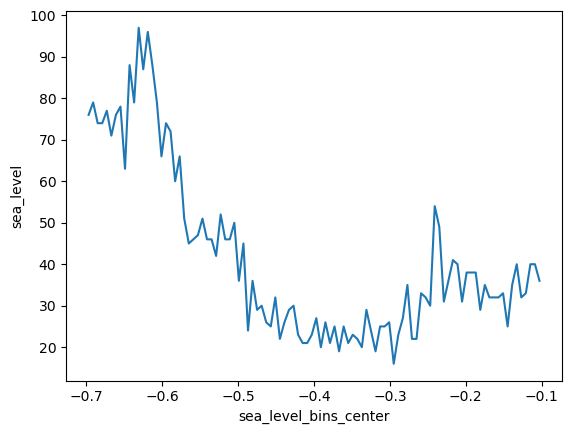

In [28]:
# amount of grid-cells/ profiles per bin
hydro_front.groupby_bins('sea_level', bins=bins).count().sea_level.plot()

In [44]:
plt.rcParams.update(plt.rcParamsDefault)

In [45]:
# fig, ax = plt.subplots(figsize=(18,6))
# along_section_on_z.CT_anom_on_isop.plot(ax=ax, x='along-section', cmap=cmo.cm.balance, vmin=-1, vmax=1)
# ax.fill_between(along_section['along-section'], along_section.ht, 5000, fc='gray', ec='k')
# ax.set_ylim([0,5000])
# ax.invert_yaxis()


In [46]:
# fig, ax = plt.subplots(figsize=(18,6))
# along_section_on_z.SA_anom_on_isop.plot(ax=ax, x='along-section', cmap=cmo.cm.delta, vmin=-.1, vmax=.1)
# ax.fill_between(along_section['along-section'], along_section.ht, 5000, fc='gray', ec='k')
# ax.set_ylim([0,5000])
# ax.invert_yaxis()

In [47]:
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})

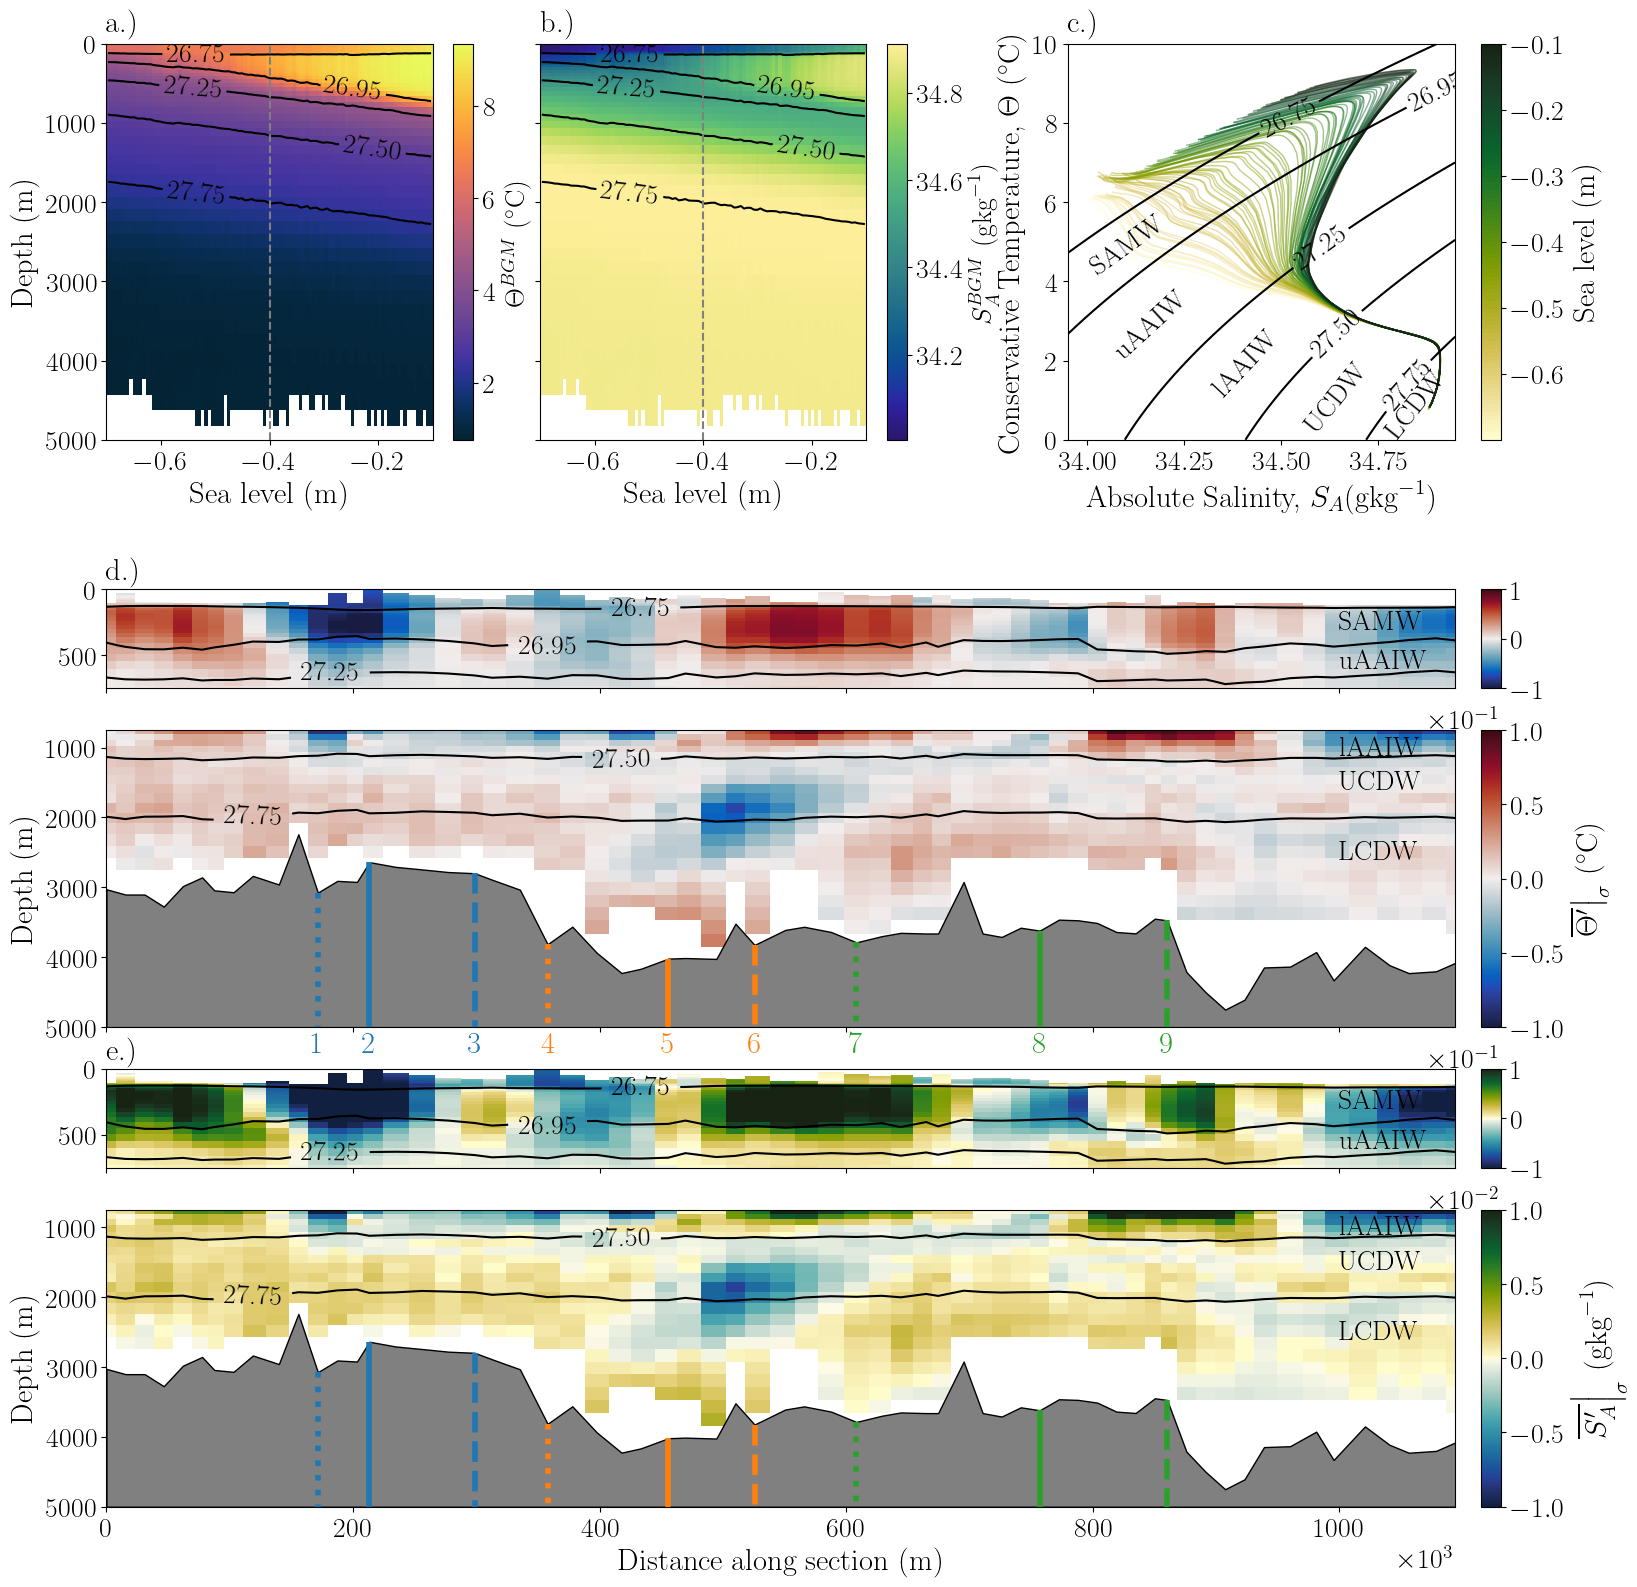

In [48]:
fig = plt.figure(figsize=(18,19), constrained_layout=True)
fig.tight_layout()

gs = plt.GridSpec(6, 5, width_ratios=[6, 6, 1, 5.7, 0.3], height_ratios=[6, 1, 1.5, 4.5, 1.5, 4.5], hspace=0.2, wspace=0.1)
plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[0, 3]), plt.subplot(gs[0, 4]),
plt.subplot(gs[2, :-1]), plt.subplot(gs[2, -1]), plt.subplot(gs[3, :-1]), plt.subplot(gs[3, -1]), 
plt.subplot(gs[4, :-1]), plt.subplot(gs[4, -1]), plt.subplot(gs[5, :-1]), plt.subplot(gs[5, -1])
ax = fig.get_axes()

### GEM PLOTS
gem.CT.plot(ax=ax[0], x='sea_level_bins', y='st_ocean', cmap=cmo.cm.thermal, 
            cbar_kwargs={'label': r'$\Theta^{BGM}$ ($^\circ \mathrm{C}$)'})
# cbar.ax.set_ylabel(r'$\overline{\Theta^\prime}$ ($^o C$)', fontsize=fs_large)

gem.SA.plot(ax=ax[1], x='sea_level_bins', y='st_ocean', cmap=cmo.cm.haline,
            cbar_kwargs={'label': r'$S_A^{BGM}$ ($\mathrm{gkg}^{-1}$)'})

for iax in range(2):
    ct = gem.sigma0.plot.contour(ax=ax[iax], x='sea_level_bins', y='st_ocean', levels=density_levels, colors='k')
    ax[iax].set_ylim([0, 5000])
    ax[iax].invert_yaxis()
    ax[iax].axvline(core_contour, linestyle='--', color='gray')
    plt.clabel(ct, fontsize=fs_small, fmt='%.2f')
    ax[iax].set_ylabel(r'Depth (m)', fontsize=fs_large)
    ax[iax].set_xlabel(r'Sea level (m)', fontsize=fs_large)
    # labelling
    ax[iax].text(0, 1.03, string.ascii_lowercase[iax] + '.)', 
                 transform=ax[iax].transAxes, size=fs_large, weight='bold')
ax[1].set_ylabel('')
ax[1].set_yticklabels('')


### T-S diagram
cmap = cmo.cm.speed
norm = mcolors.BoundaryNorm(bins, cmap.N)
mid_sl_bins = [round(val.mid,2) for val in gem.CT.sea_level_bins.values]
for i, sl in enumerate(mid_sl_bins):
    CT_gem = gem.CT.isel(sea_level_bins=i)
    SA_gem = gem.SA.isel(sea_level_bins=i)

    color = list(cmap(norm(sl)))
    color[-1] = 0.5
    pl = ax[2].plot(SA_gem, CT_gem, color=color, lw=1, markersize=8)#, linestyle='.-')

# density contours
ct = ax[2].contour(SAi, CTi, sig0grd, density_levels, colors='k')
ax[2].clabel(ct, fontsize=fs_small, fmt='%.2f')
ax[2].set_xlim([SA_min, SA_max])
ax[2].set_ylim([CT_min, CT_max])

# watermass acronyms at mid density contoura
ct = ax[2].contour(SAi, CTi, sig0grd, mid_density_levels, colors='k', linewidths=0)
fmt = {}
wm_strs = ['SAMW', 'uAAIW', 'lAAIW', 'UCDW', 'LCDW']
for l, s in zip(ct.levels, wm_strs):
    fmt[l] = s
manual_locations = [(34.1, 5), (34.2, 2.5), (34.4, 2), (34.65,1), (34.9, 0.5)]
ax[2].clabel(ct, ct.levels, inline=True, fmt=fmt, fontsize=fs_small, manual=manual_locations)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax[3], ticks=np.linspace(-0.6, -0.1, 6)) #orientation='horizontal', 
cbar.ax.set_ylabel(r'Sea level (m)', fontsize=fs_large)

ax[2].set_xlabel(r'Absolute Salinity, $S_A (\mathrm{gkg}^{-1})$', fontsize=fs_large)
ax[2].set_ylabel( r'Conservative Temperature, $\Theta$ ($^\circ \mathrm{C}$)', fontsize=fs_large)
ax[2].text(0, 1.03, string.ascii_lowercase[2] + '.)', 
             transform=ax[2].transAxes, size=fs_large, weight='bold')


### ANOMALIES ALONG-CONTOUR SECTION
# temperature (anomaly)
pcol = along_section_on_z.CT_anom_on_isop.plot(ax=ax[4], x='along-section', cmap=cmo.cm.balance, vmin=-1, vmax=1, add_colorbar=False)
cbar = fig.colorbar(pcol, ax[5])#, aspect=((1/4)*20), pad=0.02)
# cbar.update_ticks()

pcol = along_section_on_z.CT_anom_on_isop.plot(ax=ax[6], x='along-section', cmap=cmo.cm.balance, vmin=-.1, vmax=.1, add_colorbar=False)
cbar = fig.colorbar(pcol, ax[7])#, aspect=((3/4)*20), pad=0.02)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_ylabel(r'$\left .{ \overline{\Theta^\prime} }\right |_\sigma$ ($^\circ\mathrm{C}$)', fontsize=fs_large)

# salinity (anomaly)
pcol = along_section_on_z.SA_anom_on_isop.plot(ax=ax[8], x='along-section', cmap=cmo.cm.delta, vmin=-.1, vmax=.1, add_colorbar=False)
cbar = fig.colorbar(pcol, ax[9])#, aspect=((1/4)*20), pad=0.02)
cbar.formatter.set_powerlimits((0, 0))

pcol = along_section_on_z.SA_anom_on_isop.plot(ax=ax[10], x='along-section', cmap=cmo.cm.delta, vmin=-.01, vmax=.01, add_colorbar=False)
cbar = fig.colorbar(pcol, ax[11])#, aspect=((3/4)*20), pad=0.02)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_ylabel(r'$\left .{ \overline{S_A^\prime} }\right |_\sigma$ ($\mathrm{gkg}^{-1}$)', fontsize=fs_large)

wm = {'SAMW': (1000e3, 300), 
      'uAAIW': (1000e3, 600), 
      'lAAIW': (1000e3, 1100), 
      'UCDW': (1000e3, 1600),
      'LCDW': (1000e3, 2600)}

for iax in range(4, 11):

    if (iax == 4) | (iax == 6) | (iax == 8) | (iax == 10):

        # density contours
        cont = along_section.sigma0.plot.contour(
            ax=ax[iax], x='along-section', levels=density_levels, colors='k')
        ax[iax].clabel(cont, inline=1, fontsize=fs_small, fmt='%.2f', inline_spacing=10)
        
        # # watermass acronyms
        # cont = along_section.sigma0.plot.contour(
        #     ax=ax[iax], x='along-section', levels=mid_density_levels, colors='k', linewidths=0)
        # ax[iax].clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=fs_small)
            
        ax[iax].set_xlim([along_section_on_z['along-section'].min(), along_section_on_z['along-section'].max()])
        ax[iax].set_xlabel('')
        
    if (iax == 6) or (iax == 10):
        
        # depth contours
        ax[iax].fill_between(
            along_section['along-section'], along_section.ht, 5000, fc='gray', ec='k')
        
        # position cross-sections vertical lines
        for isec, (name, (coord, color, style)) in enumerate(cross_coords.items()):
            ax[iax].vlines(coord, ymin=ds.ht.sel(xt_ocean=coord.xt_ocean, yt_ocean=coord.yt_ocean, method='nearest').values, 
                            ymax=5000, color=color, lw=4, linestyle=style)
            # section numbering
            if iax == 6:
                ax[iax].text(coord, 5350, str(isec+1), color=color, ha='center', size=fs_large)
        
        # watermass acronyms
        for key, [x, y] in wm.items():
            if key in ['lAAIW', 'UCDW', 'LCDW']:
                ax[iax].text(x, y, key, fontsize=fs_small)

    if (iax == 4) | (iax == 6) | (iax == 8):
        ax[iax].set_ylim([0, 750])
        ax[iax].set_xticklabels('')
        ax[iax].set_ylabel('')
        #     # labelling
    if (iax == 4) | (iax == 8):
        
        # watermass acronyms
        for key, [x, y] in wm.items():
            if key in ['SAMW', 'uAAIW']:
                ax[iax].text(x, y, key, fontsize=fs_small)
        
        lttr = string.ascii_lowercase[3] if iax == 4 else string.ascii_lowercase[4]
        ax[iax].text(0, 1.1, lttr + '.)', transform=ax[iax].transAxes, size=fs_large, weight='bold')
        
        
    if (iax == 6) | (iax == 10):
        ax[iax].set_ylim([750, 5000])
        ax[iax].set_ylabel(r'Depth (m)', fontsize=fs_large)
    if iax == 10:
        ax[iax].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
        ax[iax].set_xlabel(r'Distance along section (m)', fontsize=fs_large)
        
    if (iax == 4) | (iax == 6) | (iax == 8) | (iax == 10):
        ax[iax].invert_yaxis()


In [51]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '04_reference-field-anomalies-along' + extension), 
                    transparent=transparent, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(-0.02, 0.5, 'Depth (m)')

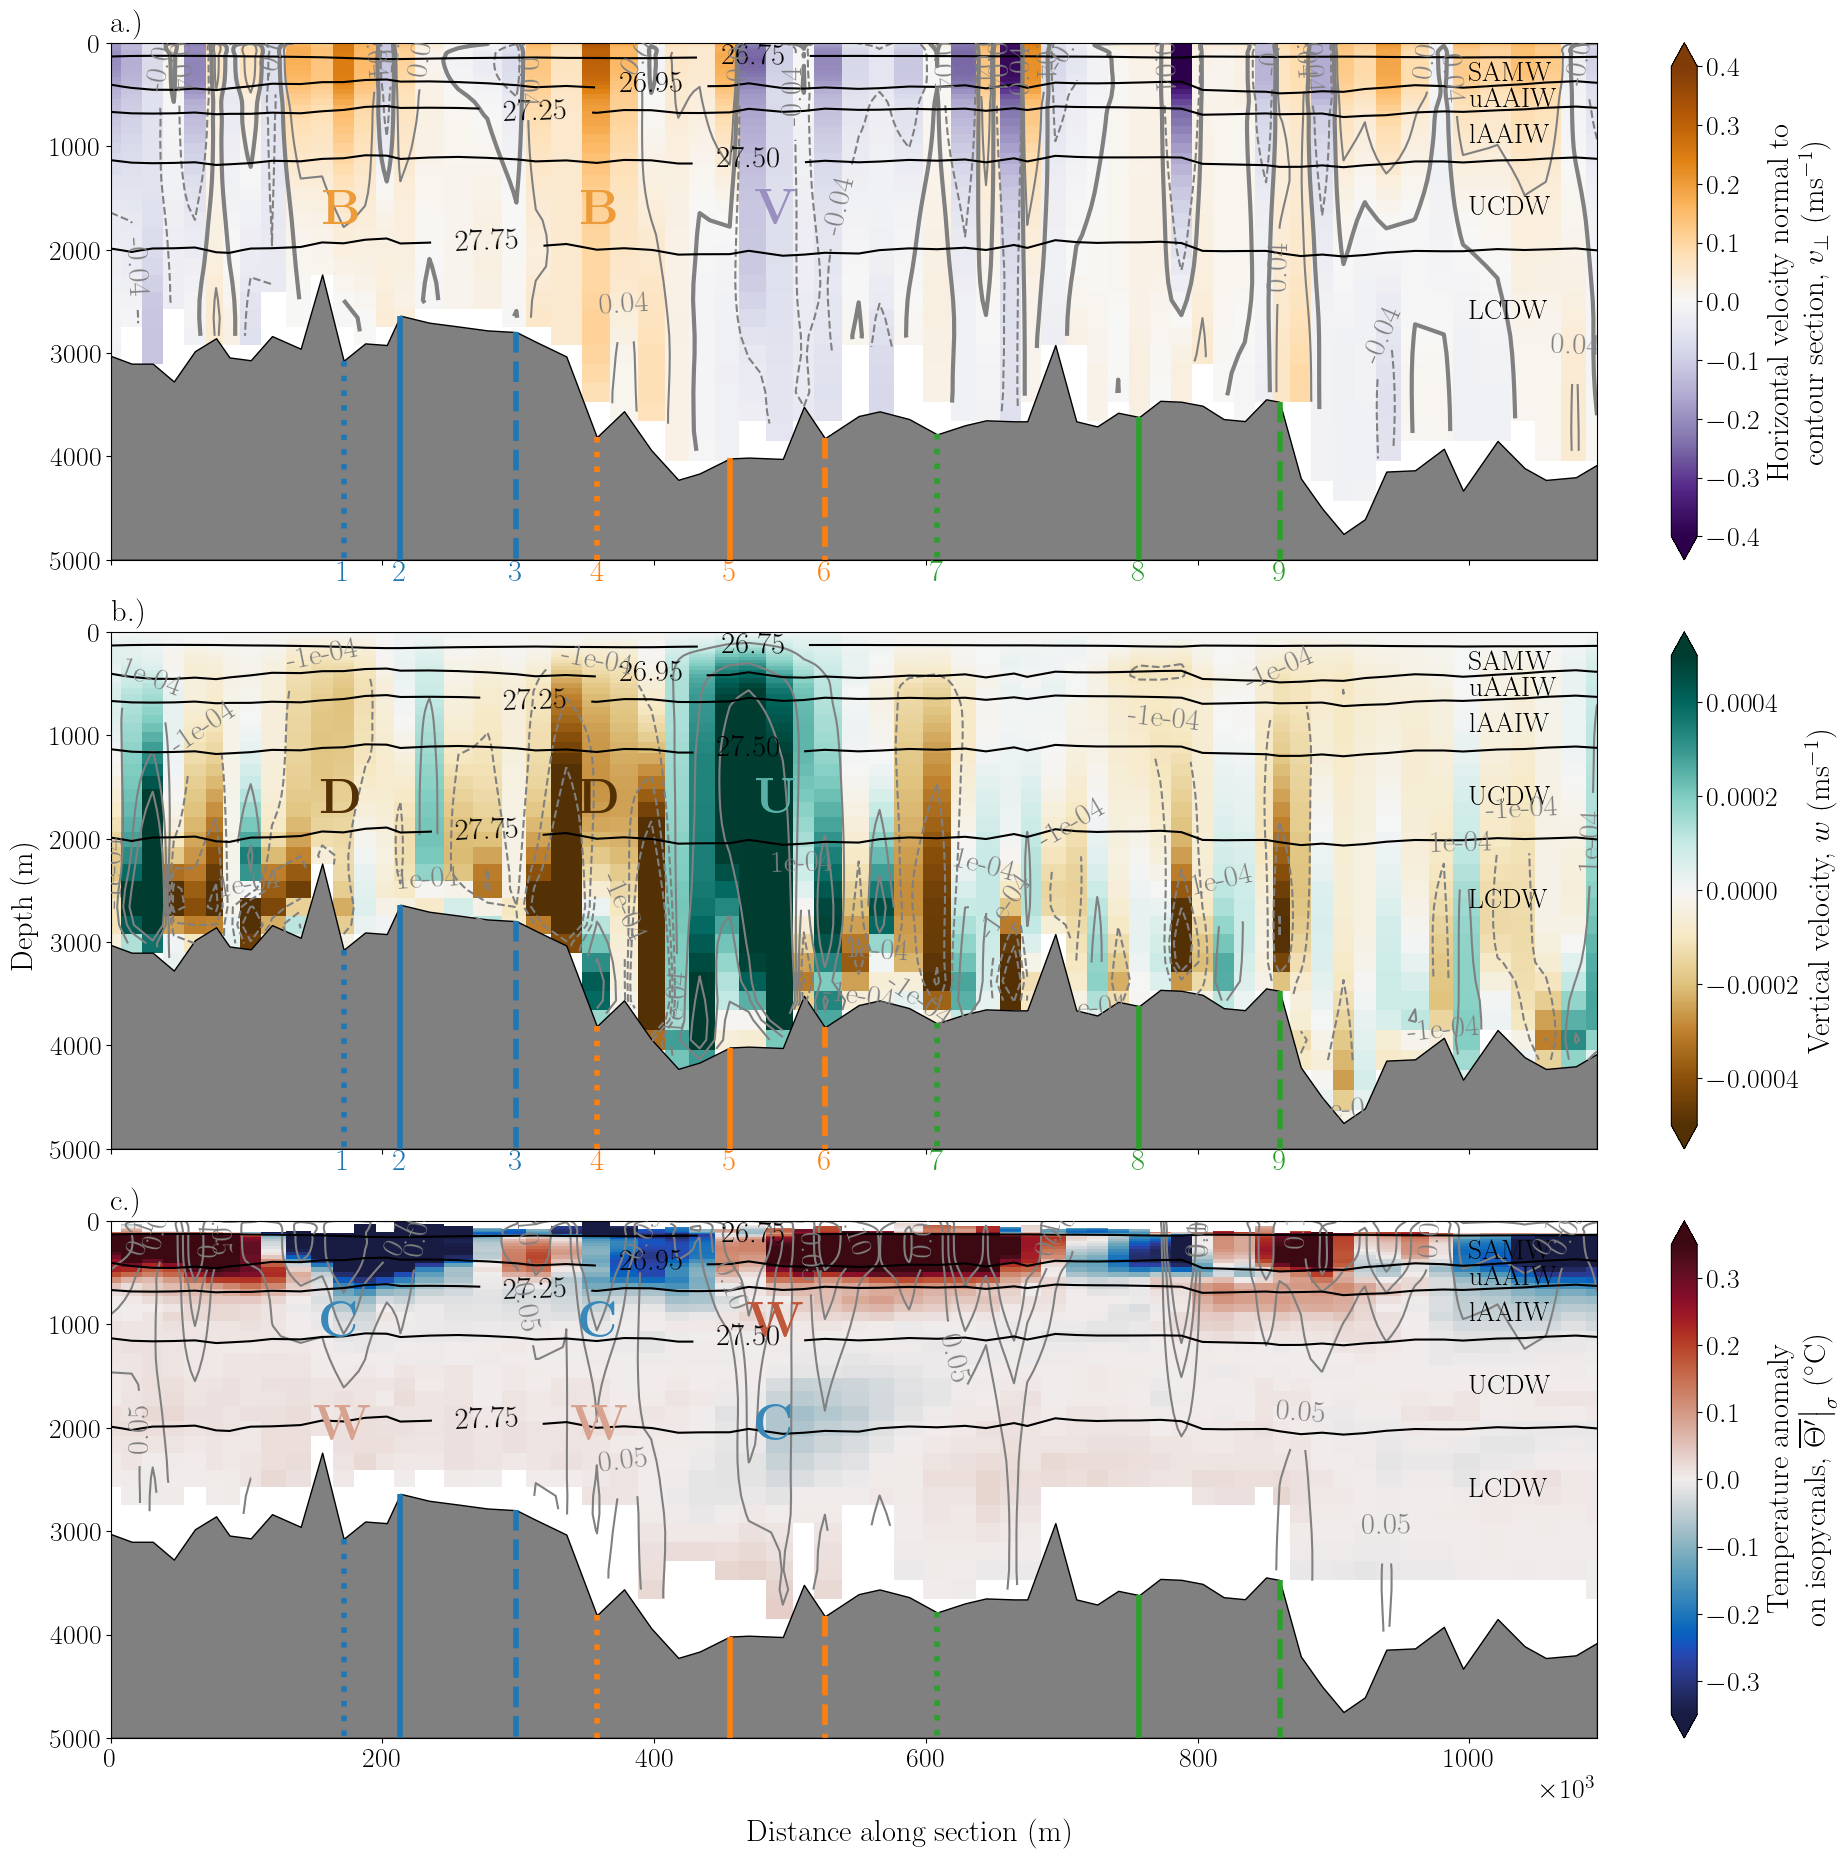

In [52]:
nrows, ncols = 3, 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18), sharex=True, constrained_layout=True)

# along_section.CT.plot(ax=ax[0], x='along-section', cmap=cmo.cm.thermal)

# cross-frontal velocities
pcol = along_section.vn.plot(ax=ax[0], x='along-section', cmap=plt.cm.PuOr_r, vmin=-0.4, vmax=0.4,
                             add_colorbar=False)
cbar = plt.colorbar(pcol, ax=ax[0], extend='both')
cbar.ax.set_ylabel('Horizontal velocity normal to\n' + r'contour section, $v_\perp$ ($\mathrm{ms}^{-1}$)', fontsize=fs_large)


ct_vn = along_section.vn.plot.contour(ax=ax[0], x='along-section', colors='gray', levels=vn_contours)

ax[0].text(170000, 1750, r'${\bf B}$', fontsize=36, color=plt.cm.PuOr_r(192), ha='center')
ax[0].text(360000, 1750, r'${\bf B}$', fontsize=36, color=plt.cm.PuOr_r(192), ha='center')
ax[0].text(490000, 1750, r'${\bf V}$', fontsize=36, color=plt.cm.PuOr_r(64), ha='center')

# vertical velocities
pcol = along_section.wt.plot(ax=ax[1], x='along-section', vmin=-.5e-3, vmax=.5e-3, cmap=plt.cm.BrBG,
    add_colorbar=False)
cbar = plt.colorbar(pcol, ax=ax[1], extend='both')
cbar.ax.set_ylabel(r'Vertical velocity, $w$ ($\mathrm{ms}^{-1}$)', fontsize=fs_large)

ct_wt = along_section.wt.plot.contour(
    ax=ax[1], x='along-section', colors='gray', levels=wt_contours)

ax[1].text(170000, 1750, r'${\bf D}$', fontsize=36, color=plt.cm.BrBG(0), ha='center')
ax[1].text(360000, 1750, r'${\bf D}$', fontsize=36, color=plt.cm.BrBG(0), ha='center')
ax[1].text(490000, 1750, r'${\bf U}$', fontsize=36, color=plt.cm.BrBG(192), ha='center')

# temperature anomaly
pcol = along_section_on_z.CT_anom_on_isop.plot(
    ax=ax[2], x='along-section', cmap=cmo.cm.balance, vmin=-.35, vmax=.35, add_colorbar=False)
cbar = plt.colorbar(pcol, ax=ax[2], extend='both')
cbar.ax.set_ylabel('Temperature anomaly\n' + r'on isopycnals, $\left .{ \overline{\Theta^\prime} }\right |_\sigma$ ($^\circ\mathrm{C}$)', fontsize=fs_large)

# cross-section speed contours
ct_spd = np.sqrt(along_section.vn**2 + along_section.wt**2).plot.contour(ax=ax[2], x='along-section', colors='gray', levels=cross_vel_contours)

ax[2].text(170000, 1000, r'${\bf C}$', fontsize=36, va='center', color=cmo.cm.balance(64), ha='center')
ax[2].text(360000, 1000, r'${\bf C}$', fontsize=36, va='center', color=cmo.cm.balance(64), ha='center')
ax[2].text(490000, 1000, r'${\bf W}$', fontsize=36, va='center', color=cmo.cm.balance(192), ha='center')

ax[2].text(171000, 2000, r'${\bf W}$', fontsize=36, va='center', color=cmo.cm.balance(160), ha='center')
ax[2].text(360000, 2000, r'${\bf W}$', fontsize=36, va='center', color=cmo.cm.balance(160), ha='center')
ax[2].text(490000, 2000, r'${\bf C}$', fontsize=36, va='center', color=cmo.cm.balance(64), ha='center')

# watermass acronyms
wm = {'SAMW': (1000e3, 300), 
      'uAAIW': (1000e3, 550), 
      'lAAIW': (1000e3, 900), 
      'UCDW': (1000e3, 1600),
      'LCDW': (1000e3, 2600)}

for iax in range(ax.size):
    
    # density contours
    cont = along_section.sigma0.plot.contour(ax=ax[iax], x='along-section', levels=density_levels, colors='k')
    ax[iax].clabel(cont, inline=1, fmt='%.2f', inline_spacing=10, fontsize=fs_large)

    for key, [x, y] in wm.items():
        ax[iax].text(x, y, key, fontsize=fs_small, va='center')
    
    # depth contours
    ax[iax].fill_between(along_section['along-section'], along_section.ht, 5000, facecolor='gray', ec='k')
    
    # position cross-sections vertical lines
    for isec, (name, (coord, color, style)) in enumerate(cross_coords.items()):
        ax[iax].vlines(coord, ymin=ds.ht.sel(xt_ocean=coord.xt_ocean, yt_ocean=coord.yt_ocean, method='nearest').values, 
                        ymax=5000, color=color, lw=4, linestyle=style)
        if iax != 2:
            ax[iax].text(coord, 5200, str(isec+1), color=color, ha='center', size=fs_large)
    
    # labelling
    ax[iax].text(0, 1.02, string.ascii_lowercase[iax] + '.)', 
                 transform=ax[iax].transAxes, size=fs_large, weight='bold')
    
    ax[iax].set_xlim([along_section['along-section'].min(), along_section['along-section'].max()])
    ax[iax].set_ylim([0,5000])
    ax[iax].invert_yaxis()
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')
    ax[iax].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))

# density contour labels (below invert_yaxis to get labels in line with countours)
plt.setp(ct_vn.collections[1], linewidth=3)
ax[0].clabel(ct_vn, vn_contours[::2], inline=True, fmt='%.2f', fontsize=fs_large)
# plt.setp(ct_wt.collections[2], linewidth=3)
ax[1].clabel(ct_wt, wt_contours[2:-2], inline=True, fmt='%.0e', fontsize=fs_large)
ax[2].clabel(ct_spd, cross_vel_contours[0:2], inline=True, fmt='%.2f', fontsize=fs_large)


fig.text(0.48, -0.02, r'Distance along section (m)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Depth (m)', va='center', rotation='vertical', fontsize=fs_large)

In [53]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '06_bcd-uvw' + extension), 
                    transparent=transparent, bbox_inches='tight')

### Appendix figure

In [54]:
taylor_terms = {
    '%s_anom_zm' : r'$\left . {%s^\prime} \right |_{z_m}$', #_{z_m}$',{\overline{\Theta^\prime} \right |$
    '%s_anom_on_isop' : r'$\left . {%s^\prime} \right |_\sigma$',#'$\left .{\overline{\Theta^\prime} \right |_\sigma$',
    '%s_anom_isop_disp' : r'$- \left.h^\prime\right|_{\sigma} \left.\frac{\partial %s^{GEM}}{\partial z}\right|_{\sigma}$',
    '%s_residual' : r'$%s^\prime$ residual'
}

Text(0, 0.5, '$\\Theta$ anomaly ($^\\circ\\mathrm{C}$)')

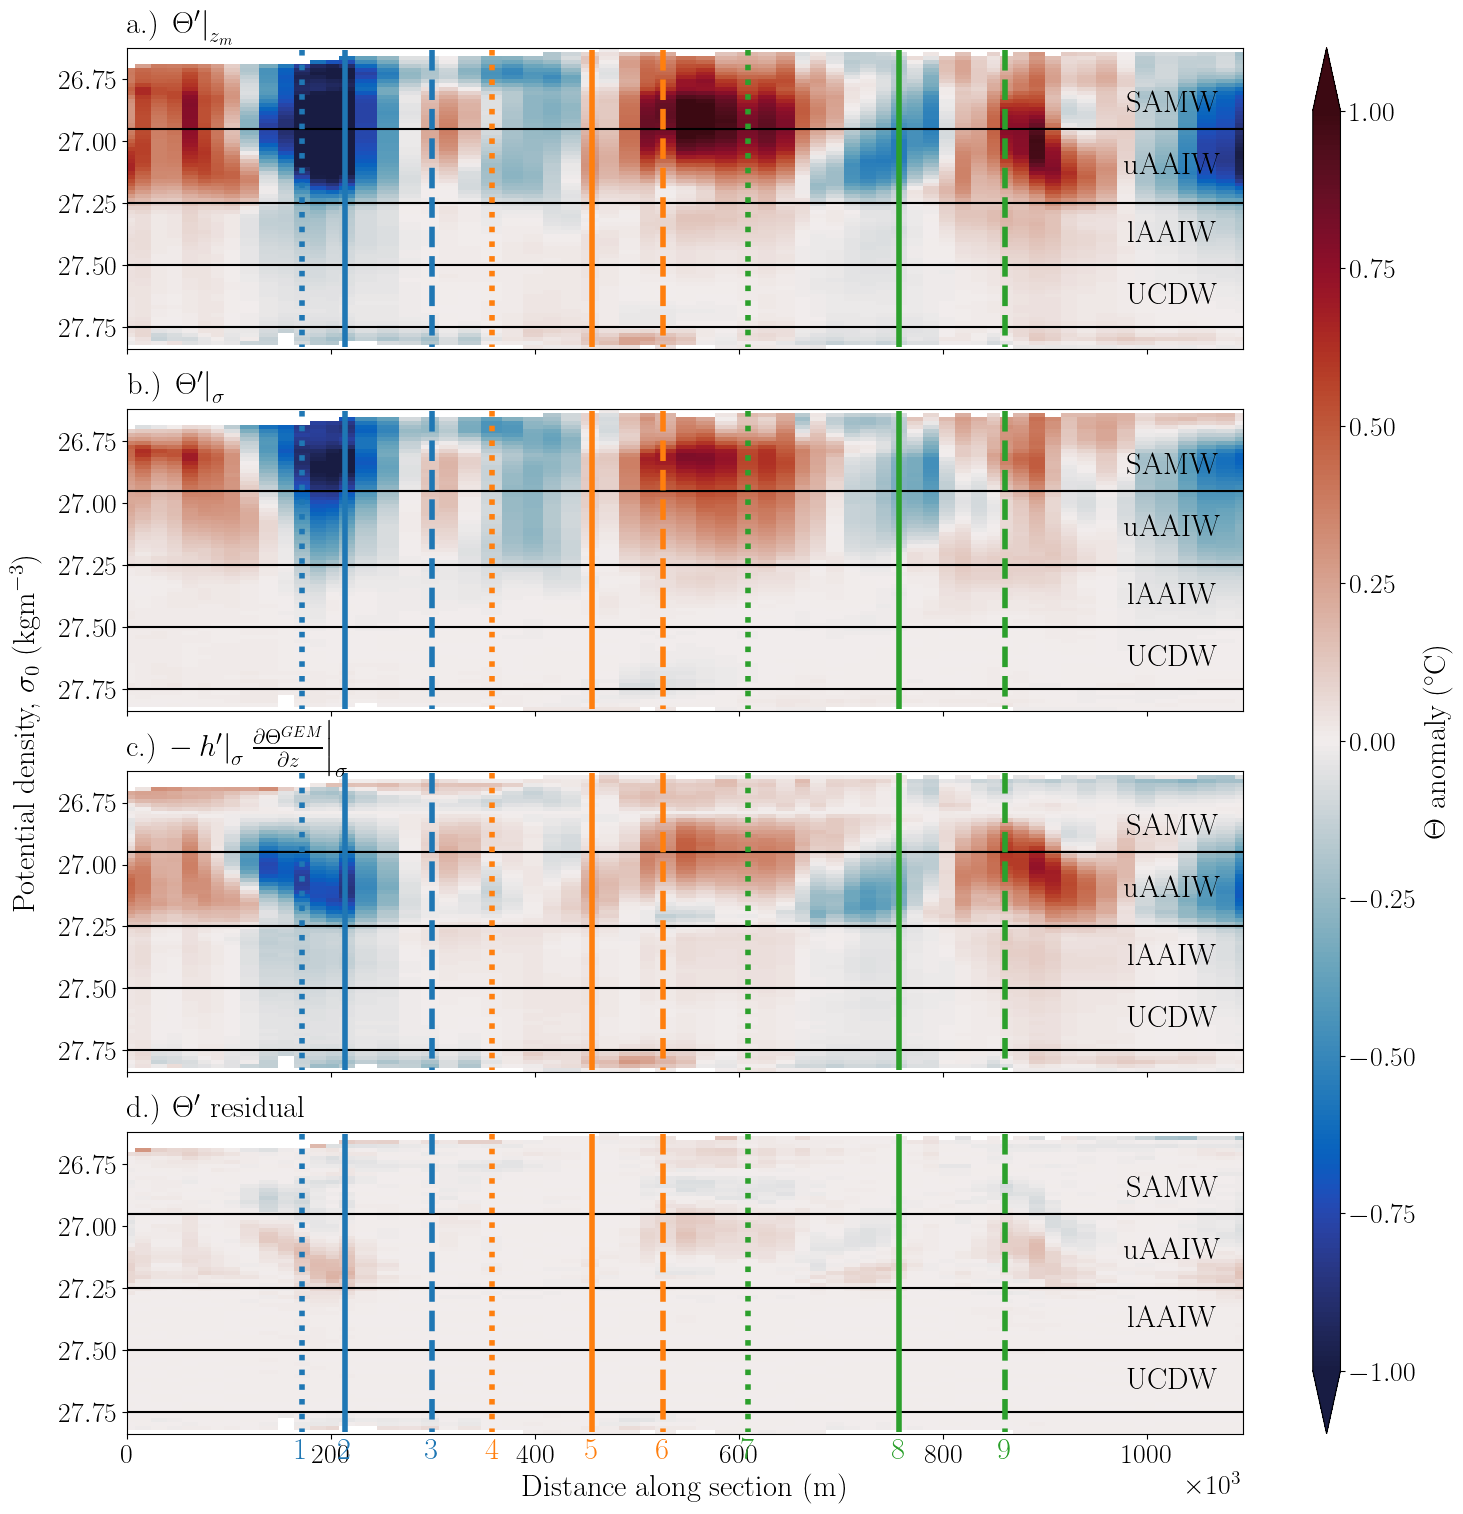

In [65]:
var = 'CT'

attrs = {
    'CT' : [ cmo.cm.balance, -1, 1], 
    'SA' : [ cmo.cm.delta, -0.15, 0.15], 
}

fig, ax = plt.subplots(nrows=4, figsize=(18,18))

for iax, (var_name, math_name) in enumerate(taylor_terms.items()):
    pcol = along_section_on_density[var_name %var].plot(
        ax=ax[iax], x='along-section', cmap=attrs[var][0], vmin=attrs[var][1], vmax=attrs[var][2], add_colorbar=False)

# for iax in range(ax.size):
    
#     # density contours
#     cont = along_section.sigma0.plot.contour(ax=ax[iax], x='along-section', levels=density_levels, colors='k')
#     ax[iax].clabel(cont, inline=1, fmt='%.1f', inline_spacing=10, fontsize=fs_large)

    # density contours
    wm_strs = ['SAMW', 'uAAIW', 'lAAIW', 'UCDW', 'LCDW']
    for dl, mid, wm in zip(density_levels[1:-2], mid_density_levels, wm_strs):
        ax[iax].axhline(dl, color='k')
        ax[iax].text(1025e3, mid, wm, fontsize=fs_large, ha='center', va='center')

    # position cross-sections vertical lines
    for isec, (name, (coord, color, style)) in enumerate(cross_coords.items()):
        ax[iax].vlines(coord, ymin=along_section_on_density.sigma0.min(), 
                        ymax=along_section_on_density.sigma0.max(), color=color, lw=4, linestyle=style)
        if iax == 3:
            ax[iax].text(coord, 27.94, str(isec+1), color=color, ha='center', size=fs_large)
            
    # labelling
    symbol = '\Theta' if var =='CT' else 'S_A'
    unit = '^\circ\mathrm{C}' if var =='CT' else '\mathrm{gkg}^{-1}'
    ax[iax].text(0, 1.05, string.ascii_lowercase[iax] + '.) %s' %(math_name %symbol), 
                 transform=ax[iax].transAxes, size=fs_large, weight='bold')
    
    ax[iax].set_xlim([along_section['along-section'].min(), along_section['along-section'].max()])
    ax[iax].invert_yaxis()
    if (iax != 3): 
        ax[iax].set_xticklabels('')
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')

ax[-1].set_xlabel('Distance along section (m)', fontsize=fs_large)
ax[-1].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))

fig.text(0.06, 0.5, r'Potential density, $\sigma_0$ (kgm$^{-3}$)', va='center', rotation='vertical', fontsize=fs_large)

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel(r'$%s$ anomaly ($%s$)' %(symbol, unit), fontsize=fs_large)

In [66]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        name = 'A1_temp-anomalies-along' if var == 'CT' else 'A2_sal-anomalies-along'
        fig.savefig(os.path.join(figsdir, name + extension), 
                    transparent=transparent, bbox_inches='tight')

In [59]:
# select data between first and last cross-section and average along-section
dist = []
for key, val in cross_coords.items():
    dist.append(val[0].values)
dist = np.array(dist)
ds_sel = along_section_on_density.sel({'along-section': slice(dist.min(), dist.max())})
ds_sel = ds_sel.mean('along-section')

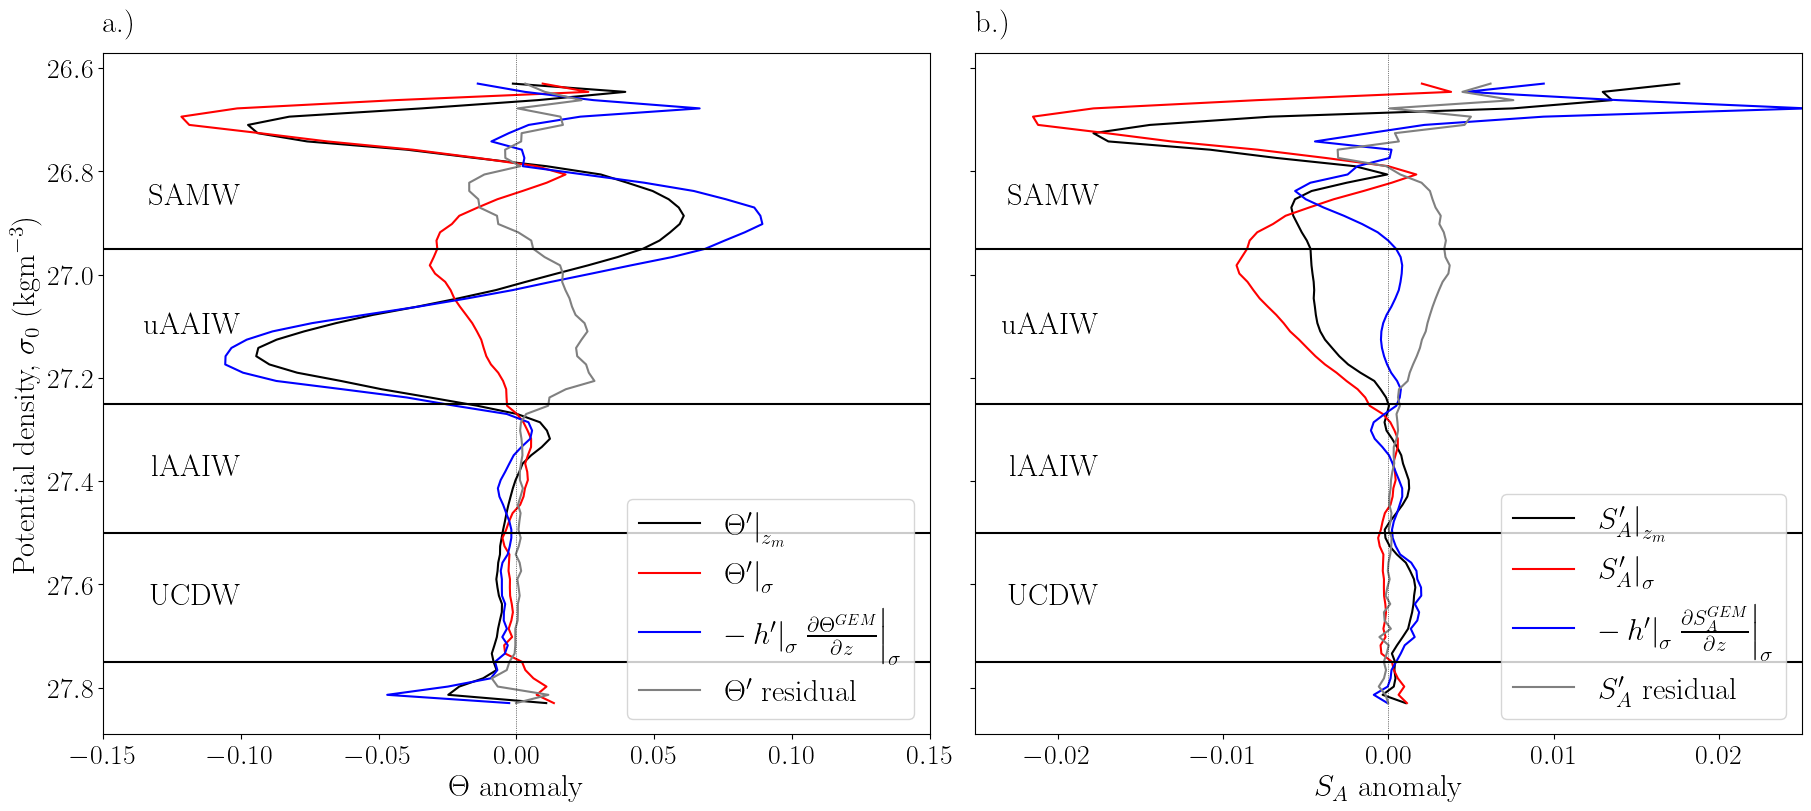

In [60]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 8), constrained_layout=True)

colors = ['k', 'r', 'b', 'gray']

var = 'CT'
symbol= '\Theta'
for icol, (var_name, math_name) in enumerate(taylor_terms.items()):
    ds_sel[var_name %var].plot(ax=ax[0], y='sigma0', color=colors[icol], label=(math_name %symbol))
ax[0].set_xlim([-0.15, 0.15])
ax[0].set_xlabel(r'$%s$ anomaly' %symbol, fontsize=fs_large)

var = 'SA'
symbol = 'S_A'
for icol, (var_name, math_name) in enumerate(taylor_terms.items()):
    ds_sel[var_name %var].plot(ax=ax[1], y='sigma0', color=colors[icol], label=(math_name %symbol))
ax[1].set_xlim([-0.025, 0.025])
ax[1].set_xlabel(r'$%s$ anomaly' %symbol, fontsize=fs_large)

for iax in range(ax.size):

    # labelling
    ax[iax].text(0, 1.03, string.ascii_lowercase[iax] + '.)', 
                 transform=ax[iax].transAxes, size=fs_large, weight='bold')
    
    # density levels
    wm_strs = ['SAMW', 'uAAIW', 'lAAIW', 'UCDW', 'LCDW']
    for dl, mid, wm in zip(density_levels[1:-2], mid_density_levels, wm_strs):
        ax[iax].axhline(dl, color='k')
        xlbl = -0.1 if iax == 0 else -0.0175
        ax[iax].text(xlbl, mid, wm, fontsize=fs_large, va='center', ha='right')
    
    ax[iax].axvline(x=0, linestyle='dotted', linewidth=0.5, color='k')
    ax[iax].legend(loc='lower right', fontsize=fs_large)
    if iax == 1:
        ax[iax].set_ylabel('')
        ax[iax].set_yticklabels('', fontsize=fs_small)
    ax[iax].invert_yaxis()

ax[0].set_ylabel(r'Potential density, $\sigma_0$ (kgm$^{-3}$)', fontsize=fs_large)
plt.show()

In [61]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, 'A3_avg-anomalies-along' + extension), 
                    transparent=transparent, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
## Isopycnal displacement

In [ ]:
watermass = {
    'ML': (26.6, 26.75),
    'SAMW': (26.75, 26.95),
    'AAIW': (26.95, 27.25, 27.5),
    'UCDW': (27.5, 27.75),
    'LCDW': (27.75, 28.27),
    'AABW': (28.27, 28.5) # water with a <0 potential temperature

ML 26.75
SAMW 26.95
uAAIW 27.25
lAAIW 27.5
UCDW 27.75
LCDW inf


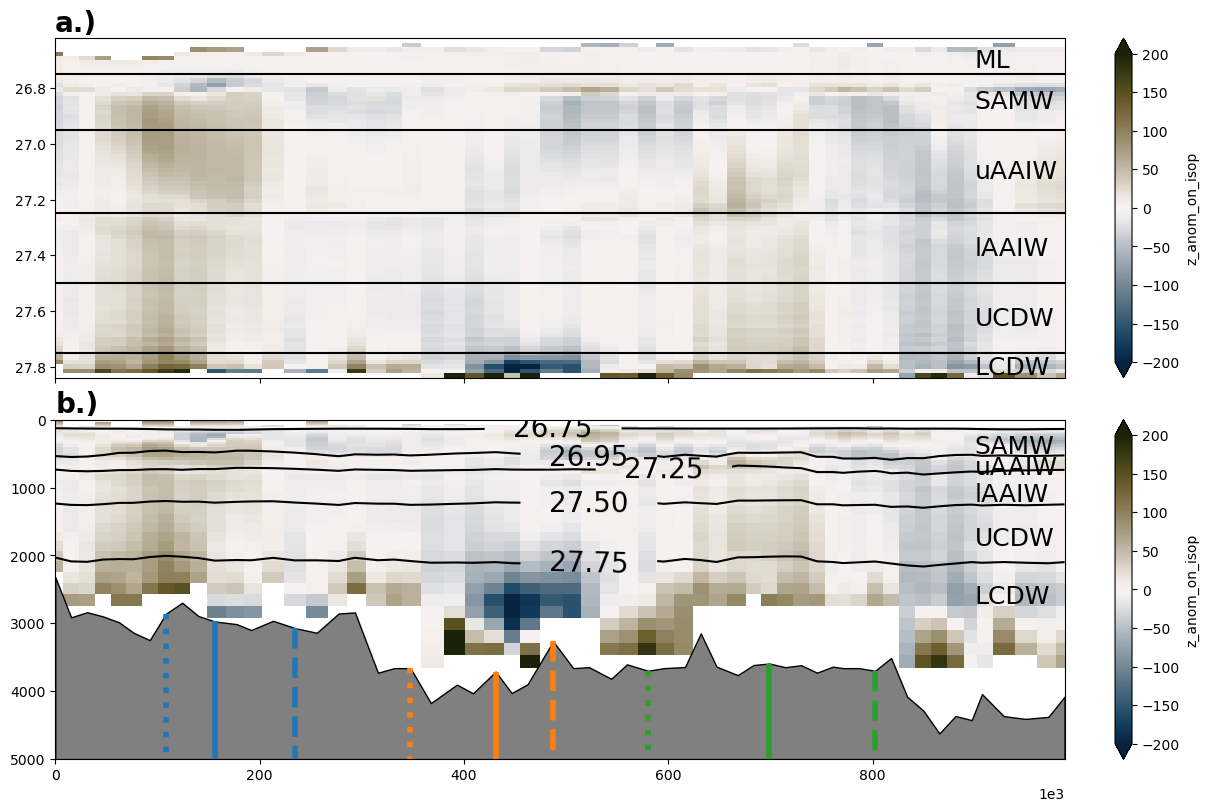

In [63]:
nrows, ncols = 2, 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8), sharex=True, constrained_layout=True)

along_section_on_density.z_anom_on_isop.plot(ax=ax[0], x='along-section', cmap=cmo.cm.diff, vmin=-200, vmax=200)
along_section_on_z.z_anom_on_isop.plot(ax=ax[1], x='along-section', cmap=cmo.cm.diff, vmin=-200, vmax=200)

iax = 0
wm = {'ML': (900e3, 26.7, 26.75),
      'SAMW': (900e3, 26.85, 26.95), 
      'uAAIW': (900e3, 27.1, 27.25), 
      'lAAIW': (900e3, 27.375, 27.5), 
      'UCDW': (900e3, 27.625, 27.75),
      'LCDW': (900e3, 27.8, np.inf)}
for key, (hc, mc, vc) in wm.items():
    print(key, vc)
    ax[iax].axhline(vc, color='k')
    ax[iax].text(hc, mc, key, fontsize=fs_small, va='center')

iax = 1
# density contours
cont = along_section.sigma0.plot.contour(ax=ax[iax], x='along-section', levels=density_levels, colors='k')
ax[iax].clabel(cont, inline=1, fmt='%.2f', inline_spacing=10, fontsize=fs_large)

# watermass acronyms
wm = {'SAMW': (900e3, 400), 
      'uAAIW': (900e3, 700), 
      'lAAIW': (900e3, 1100), 
      'UCDW': (900e3, 1750),
      'LCDW': (900e3, 2600)}
for key, [x, y] in wm.items():
    ax[iax].text(x, y, key, fontsize=fs_small, va='center')
    
# depth contours
ax[iax].fill_between(along_section['along-section'], along_section.ht, 5000, facecolor='gray', ec='k')

# position cross-sections vertical lines
for name, (coord, color, style) in cross_coords.items():
    ax[iax].vlines(coord, ymin=ds.ht.sel(xt_ocean=coord.xt_ocean, yt_ocean=coord.yt_ocean, method='nearest').values, 
                    ymax=5000, color=color, lw=4, linestyle=style)

ax[iax].set_ylim([0,5000])
    
for iax in range(ax.size):

    # labelling
    ax[iax].text(0, 1.02, string.ascii_lowercase[iax] + '.)', 
                 transform=ax[iax].transAxes, size=fs_large, weight='bold')
    
    ax[iax].set_xlim([along_section['along-section'].min(), along_section['along-section'].max()])
    ax[iax].invert_yaxis()

    ax[iax].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')

In [36]:
# plt.rcParams.update(plt.rcParamsDefault)

In [37]:
# cmap = cmo.cm.speed
# norm = mcolors.BoundaryNorm(bins, cmap.N)

# fig, ax = plt.subplots(figsize=(18,10), ncols=3)

# gem.CT.plot(ax=ax[0], x='sea_level_bins', y='st_ocean', cmap=cmo.cm.thermal, 
#             cbar_kwargs={'orientation': 'horizontal'})
# gem.SA.plot(ax=ax[1], x='sea_level_bins', y='st_ocean', cmap=cmo.cm.haline,
#             cbar_kwargs={'orientation': 'horizontal'})

# for iax in range(len(ax)-1):
#     ct = gem.sigma0.plot.contour(ax=ax[iax], x='sea_level_bins', y='st_ocean', levels=density_levels, colors='k')
#     plt.clabel(ct, fontsize=fs_small, fmt='%.2f')
#     ax[iax].set_ylim([0, 5000])
#     ax[iax].invert_yaxis()

# mid_sl_bins = [round(val.mid,2) for val in gem.CT.sea_level_bins.values]
# for i, sl in enumerate(mid_sl_bins):
#     CT_gem = gem.CT.isel(sea_level_bins=i)
#     SA_gem = gem.SA.isel(sea_level_bins=i)

#     color = list(cmap(norm(sl)))
#     color[-1] = 0.5
#     pl = ax[2].plot(SA_gem, CT_gem, color=color, lw=1, markersize=8)#, linestyle='.-')

# ct = ax[2].contour(SAi, CTi, sig0grd, density_levels, colors='k')
# ax[2].clabel(ct, fontsize=fs_small, fmt='%.2f')
# # ax[2].set_xlim([34.6, 34.95])
# # ax[2].set_ylim([0.5, 3.5])

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# fig.colorbar(sm, ax=ax[2], orientation='horizontal', ticks=np.linspace(-0.6, -0.1, 6))


In [38]:
# plt.show()

## Anomalies on isopycnals and due to isopycnal displacement

In [39]:
var_attrs = {
    'CT' : [cmo.cm.thermal, 1, 9, r'$\left.\Theta^\prime\right|_{z}$'],
    'CT_anom_zm' : [cmo.cm.balance, -1, 1, r'$\left.\Theta^\prime\right|_{z_m}$'],
    'CT_gem' : [cmo.cm.thermal, 1, 9, ''],
    'CT_anom': [cmo.cm.balance, -1, 1, r'$\left.\Theta^\prime\right|_{\sigma}$'],
    'CT_anom_isop_disp': [cmo.cm.balance, -1, 1, r'$- \left.h^\prime\right|_{\sigma} \left.\frac{\partial\Theta^{GEM}}{\partial z}\right|_{\sigma}$'],
    'dCTdz_gem': [cmo.cm.balance, -0.1, 0.1, r'$\left.\frac{\partial\Theta^{GEM}}{\partial z}\right|_{\sigma}$'],
    'SA': [cmo.cm.haline, 34.0, 34.9, ''],
    'SA_zm': [cmo.cm.haline, 34.0, 34.9, ''],
    'SA_gem': [cmo.cm.haline, 34.0, 34.9, ''],
    'SA_anom': [cmo.cm.delta, -0.1, 0.1, ''],
    'SA_anom_isop_disp': [cmo.cm.delta, -0.1, 0.1, ''],
    'dSAdz_gem': [cmo.cm.delta, -0.1, 0.1, ''],
    'h_anom': [cmo.cm.diff, -80, 80, r'$\left.h^\prime\right|_{\sigma}$']
}

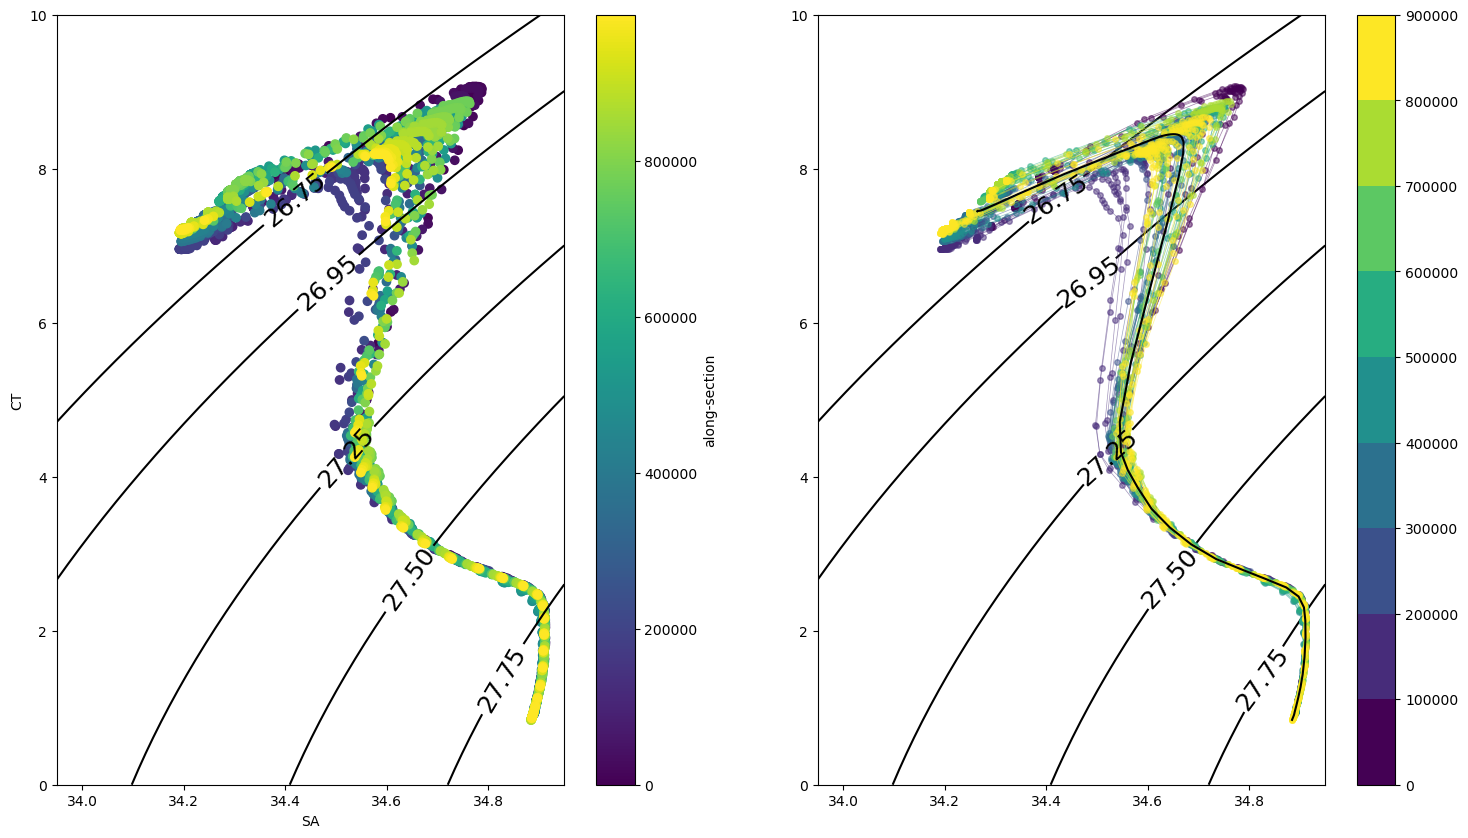

In [40]:
cmap = plt.cm.viridis
bounds = np.linspace(0, 900000, 10)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(ncols=2, figsize=(18,10))

along_section.plot.scatter(ax=ax[0], x='SA', y='CT', hue='along-section', cmap=cmap)
ct = ax[0].contour(SAi, CTi, sig0grd, density_levels, colors='k')
ax[0].clabel(ct, fontsize=fs_small, fmt='%.2f')


for i,dist in enumerate(along_section['along-section']):
    along_section_CT = along_section.CT.isel({'along-section': i})
    along_section_SA = along_section.SA.isel({'along-section': i})

    color = list(cmap(norm(dist)))
    color[-1] = 0.5
    pl = ax[1].plot(along_section_SA, along_section_CT, '.-', color=color, lw=0.5, markersize=8)

ax[1].plot(along_section.SA.mean('along-section'), along_section.CT.mean('along-section'), 'k')

ct = ax[1].contour(SAi, CTi, sig0grd, density_levels, colors='k')
ax[1].clabel(ct, fontsize=fs_small, fmt='%.2f')

ax[1].set_xlim([SA_min, SA_max])
ax[1].set_ylim([CT_min, CT_max])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax[1])

In [41]:
dist = along_section['along-section'].values

x = along_section.SA.values
y = along_section.CT.values
xmean = along_section.SA.mean('along-section').values
ymean = along_section.CT.mean('along-section').values

def play(interval=200):
    fig, ax = plt.subplots(figsize=(10,16), nrows=2, gridspec_kw={'height_ratios':[5,11]})
    
    ds.wt.isel(st_ocean=30).plot(ax=ax[0],vmin=-1e-4, vmax=1e-4, cmap=plt.cm.BrBG)
    ds.sea_level.plot.contour(ax=ax[0], levels=[-0.55, -0.3, -0.05], colors='k', linestyles='solid')
    loc = ax[0].plot(along_section.xt_ocean[0], along_section.yt_ocean[0], '.', markersize=20)
    
    ct = ax[1].contour(SAi, CTi, sig0grd, density_levels, colors='gray')
    ax[1].clabel(ct, fmt='%.2f')
    
    ax[1].plot(xmean, ymean, color='k')
    graph = ax[1].plot(xmean, ymean, color='k', lw=5)
    ax[1].set_xlim([34.15, 34.95])
    ax[1].set_ylim([0.5, 9.5])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm, ax=ax[1], orientation='horizontal', extend='max')

    def animate(i):
        graph[0].set_data(x[i], y[i])
        color = list(cmap(norm(dist[i])))
        graph[0].set_color(color)
        
        loc[0].set_data(along_section.xt_ocean[i], along_section.yt_ocean[i])
        loc[0].set_color(color)

        ax[1].set_title('Distance along section: %s km' %round((dist[i]/1000),0))

        return graph, loc


    anim = animation.FuncAnimation(fig, animate, frames=len(dist), interval=interval)
    
    return anim

In [ ]:
anim = play()
display_animation(anim)

In [ ]:
# ds.where((ds.sea_level > -0.6) & (ds.sea_level < -0.1)).plot.scatter(size=8, x='SA', y='CT', hue='sea_level')
# ct = plt.contour(SAi, CTi, sig0grd, density_levels, colors='k')
# plt.clabel(ct, fontsize=fs_small, fmt='%.2f')

In [ ]:
fig = plt.figure(figsize=(18,12), constrained_layout=True)
fig.tight_layout()

gs = plt.GridSpec(4, 2, width_ratios=[16,4], height_ratios=[1.5, 4.5, 1.5, 4.5], hspace=0.25, wspace=5e-3)
plt.subplot(gs[0, 0]), plt.subplot(gs[1, 0]), plt.subplot(gs[2, 0]), plt.subplot(gs[3, 0]), plt.subplot(gs[:3, 1])
ax = fig.get_axes()

# temperature (anomaly)
# along_section.CT.plot(ax=ax[0], x='along-section', cmap=cmo.cm.thermal)
pcol = along_section.CT_anom.plot(
    ax=ax[0], x='along-section', cmap=cmo.cm.balance, vmin=-1, vmax=1, 
    add_colorbar=False)
# pcol = (along_section.CT - along_section.CT.mean('along-section')).plot(
#     ax=ax[0], x='along-section', cmap=cmo.cm.balance, vmin=-1, vmax=1, 
#     add_colorbar=False)
cbar = plt.colorbar(pcol, ax=ax[0], aspect=((1/4)*20), pad=0.02)

pcol = along_section.CT_anom.plot(
    ax=ax[1], x='along-section', cmap=cmo.cm.balance, vmin=-0.5, vmax=0.5, 
    add_colorbar=False)
# pcol = (along_section.CT - along_section.CT.mean('along-section')).plot(
#     ax=ax[1], x='along-section', cmap=cmo.cm.balance, vmin=-0.5, vmax=0.5, 
#     add_colorbar=False)
cbar = plt.colorbar(pcol, ax=ax[1], aspect=((3/4)*20), pad=0.02)
cbar.ax.set_ylabel(r'$\overline{\Theta^\prime}$ ($^o C$)', fontsize=fs_large)

# # salinity (anomaly)
# along_section.SA.plot(ax=ax[3], x='along-section', cmap=cmo.cm.haline)
# pcol = (along_section.SA - along_section.SA.mean('along-section')).plot(
#     ax=ax[2], x='along-section', cmap=cmo.cm.delta, vmin=-.15, vmax=.15, 
#     add_colorbar=False)
pcol = along_section.SA_anom.plot(
    ax=ax[2], x='along-section', cmap=cmo.cm.delta, vmin=-.15, vmax=.15, 
    add_colorbar=False)
cbar = plt.colorbar(pcol, ax=ax[2], aspect=((1/4)*20), pad=0.02)

# pcol = (along_section.SA - along_section.SA.mean('along-section')).plot(
#     ax=ax[3], x='along-section', cmap=cmo.cm.delta, vmin=-.05, vmax=.05,
#     add_colorbar=False)
pcol = along_section.SA_anom.plot(
    ax=ax[3], x='along-section', cmap=cmo.cm.delta, vmin=-.05, vmax=.05,
    add_colorbar=False)
cbar = plt.colorbar(pcol, ax=ax[3], aspect=((3/4)*20), pad=0.02)
cbar.ax.set_ylabel(r'$\overline{S_A^\prime}$ ($gkg^{-1}$)', fontsize=fs_large)


# T-S diagram
cmap = plt.get_cmap("viridis")
bounds = np.linspace(0, 900000, 10)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for i,dist in enumerate(along_section['along-section']):
    along_section_CT = along_section.CT.isel({'along-section': i})
    along_section_SA = along_section.SA.isel({'along-section': i})

    color = list(cmap(norm(dist)))
    color[-1] = 0.5
    pl = ax[4].plot(along_section_SA, along_section_CT, 
                 '.-', color=color, lw=0.5, markersize=8)#, markerfacecolor=(1, 1, 1, 0.5))
ax[4].plot(along_section.SA.mean('along-section'), along_section.CT.mean('along-section'), 'k')

ct = ax[4].contour(SAi, CTi, sig0grd, density_levels, colors='k')
ax[4].clabel(ct, fontsize=fs_small, fmt='%.2f')
    
# watermass acronyms
ct = ax[4].contour(SAi, CTi, sig0grd, mid_density_levels, colors='k', linewidths=0)
fmt = {}
wm_strs = ['SAMW', 'uAAIW', 'lAAIW', 'UCDW', 'LCDW']
for l, s in zip(ct.levels, wm_strs):
    fmt[l] = s
# manual_locations = [(-49.5, 100), (-48, 400), (-47, 700), (-49, 800), (-53, 600), (-52.5, 1300)]
ax[4].clabel(ct, ct.levels, inline=True, fmt=fmt, fontsize=fs_small)#, manual=manual_locations)


ax[4].set_xlim([SA_min, SA_max])
ax[4].set_ylim([CT_min, CT_max])
ax[4].set_xlabel(r'Absolute Salinity, $S_A$ ($gkg^{-1}$)', fontsize=fs_large)
ax[4].set_ylabel( r'Conservative Temperature, $\Theta$ ($^o C$)', fontsize=fs_large)
ax[4].text(0, 1.03, string.ascii_lowercase[2] + '.)', 
             transform=ax[4].transAxes, size=fs_large, weight='bold')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax[4], orientation='horizontal', pad=0.15)
cbar.ax.set_xlabel(r'Along-section distance (m)', fontsize=fs_large)
cbar.formatter.set_powerlimits((3, 3))
cbar.update_ticks()

for iax in range(len(ax)-1):
#     r, c = iax // ncols, iax % ncols

    # density contours
    cont = along_section.sigma0.plot.contour(
        ax=ax[iax], x='along-section', levels=density_levels, colors='k')
    ax[iax].clabel(cont, inline=1, fontsize=fs_small, fmt='%.2f', inline_spacing=10)
    # watermass acronyms
    cont = along_section.sigma0.plot.contour(
        ax=ax[iax], x='along-section', levels=mid_density_levels, colors='k', linewidths=0)
    ax[iax].clabel(cont, cont.levels, inline=True, fmt=fmt, fontsize=fs_small)
    
    if (iax != 0) or (iax != 2):
        
        # depth contours
        ax[iax].fill_between(
            along_section['along-section'], along_section.ht, 5000, fc='gray', ec='k')
        
        # position cross-sections vertical lines
        for name, (coord, color, style) in cross_coords.items():
            ax[iax].vlines(coord, ymin=ds.ht.sel(xt_ocean=coord.xt_ocean, yt_ocean=coord.yt_ocean, method='nearest').values, 
                            ymax=5000, color=color, lw=4, linestyle=style)
    
    # labelling
    if not (iax == 1) | (iax == 3):
        lttr = string.ascii_lowercase[iax] if iax < 2 else string.ascii_lowercase[iax-1]
        ax[iax].text(0, 1.1, lttr + '.)', 
                     transform=ax[iax].transAxes, size=fs_large, weight='bold')
    
    ax[iax].set_xlim([along_section['along-section'].min(), along_section['along-section'].max()])
    ax[iax].set_xlabel('')
    if (iax == 0) | (iax == 2):
        ax[iax].set_ylim([0, 750])
        ax[iax].set_xticklabels('')
        ax[iax].set_ylabel('')
    if (iax == 1) | (iax == 3):
        if iax == 1:
            ax[iax].set_xticklabels('')
        if iax == 3:
            ax[iax].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
            ax[iax].set_xlabel(r'Along-section distance (m)', fontsize=fs_large)
        ax[iax].set_ylim([750, 5000])
        ax[iax].set_ylabel(r'Depth (m)', fontsize=fs_large)

    ax[iax].invert_yaxis()


# spacing and numbering
# fig.subplots_adjust(hspace=0.1)
# ax = fig.get_axes()
# for iax, num in zip([0, 1, 2, 3, 4], [0, 2, 4, 5, 6]):
#     spacing = 1.05 if num > 1 else 1.1
#     ax[num].text(0, spacing, string.ascii_lowercase[iax] + '.)', 
#                  transform=ax[num].transAxes, size=fs_large, weight='bold')

In [ ]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '04_temp-sal-anomalies' + extension), 
                    transparent=transparent, bbox_inches='tight')

distributed.nanny - WARNING - Restarting worker
